## Classifier analysis part 2 (Supp. Figure 3)

This notebook applies augur to calculate AUC scores for each cell type in each condition. Because the version of Augur that we used is not compatible with the version of Seurat primarily used throughout the project, this notebook calculates AUC scores on seurat objects that are transformed to a previous version of Seurat. Part 2 will then detail how we performed analysis on these values.

#### Import libraries

In [1]:
library(Seurat)
library(dplyr)
library(magrittr)
library(ggplot2)
library(xlsx)
library(tidyr)
library(scales)
library(reshape2)

Attaching SeuratObject


Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union



Attaching package: 'tidyr'


The following object is masked from 'package:magrittr':

    extract



Attaching package: 'reshape2'


The following object is masked from 'package:tidyr':

    smiths




#### Loading .rds files

In [2]:
LS.integrated <- readRDS('C:/Users/stuberadmin/Documents/scRNAseq/211119-RS-rv4/Neurons_only_iter2/LS_integrated.rds')

In [3]:
LS_sal<-readRDS(file = "C:/Users/stuberadmin/Documents/scRNAseq/211119-RS/Neurons_only_iter5/LS_sal.rds")
LS_mor<-readRDS(file = "C:/Users/stuberadmin/Documents/scRNAseq/211119-RS/Neurons_only_iter5/LS_mor.rds")
LS_nal<-readRDS(file = "C:/Users/stuberadmin/Documents/scRNAseq/211119-RS/Neurons_only_iter5/LS_nal.rds")
LS_one_mor<-readRDS( file = "C:/Users/stuberadmin/Documents/scRNAseq/211119-RS/Neurons_only_iter5/LS_one_mor.rds")
LS_nal_no_mor<-readRDS( file = "C:/Users/stuberadmin/Documents/scRNAseq/211119-RS/Neurons_only_iter5/LS_nal_no_mor.rds")

#### Assigning cell identities

In [4]:
new.ident <- c("Gaba1","Gaba2","Gaba3","Gaba4","Gaba5","Gaba6","Gaba7","Glu1","Gaba8","Gaba9","Gaba10","Glu2","Gaba11","Gaba12")
names(x = new.ident) <- levels(x =LS.integrated)
LS.integrated<- RenameIdents(object =LS.integrated, new.ident)

In [5]:
table(Idents(LS.integrated))


 Gaba1  Gaba2  Gaba3  Gaba4  Gaba5  Gaba6  Gaba7   Glu1  Gaba8  Gaba9 Gaba10 
  3124   2731   2316   2248   2157   2116   2028   1919   1904   1860   1634 
  Glu2 Gaba11 Gaba12 
  1015    437    118 

In [6]:
for (i in 1:length(new.ident)){
assign(paste(new.ident[i],"_barcode",sep=""),colnames(LS.integrated@assays$RNA@data[,which(Idents(object=LS.integrated) %in% new.ident[i])]))# this gives all barcodes in cluster
assign(paste(new.ident[i],"_barcode_LS_sal",sep=""),intersect(colnames(LS_sal@assays$RNA@data),eval(parse(text = paste(new.ident[i],"_barcode",sep="")))))
assign(paste(new.ident[i],"_barcode_LS_mor",sep=""),intersect(colnames(LS_mor@assays$RNA@data),eval(parse(text = paste(new.ident[i],"_barcode",sep="")))))
assign(paste(new.ident[i],"_barcode_LS_nal",sep=""),intersect(colnames(LS_nal@assays$RNA@data),eval(parse(text = paste(new.ident[i],"_barcode",sep="")))))
assign(paste(new.ident[i],"_barcode_LS_one_mor",sep=""),intersect(colnames(LS_one_mor@assays$RNA@data),eval(parse(text = paste(new.ident[i],"_barcode",sep="")))))
assign(paste(new.ident[i],"_barcode_LS_nal_no_mor",sep=""),intersect(colnames(LS_nal_no_mor@assays$RNA@data),eval(parse(text = paste(new.ident[i],"_barcode",sep="")))))
}

In [7]:
celltype<-vector()
for (i in 1:dim(LS.integrated@meta.data)[1]){
    celltype[i]<-toString(new.ident[LS.integrated@meta.data$integrated_snn_res.0.2[i]])
}
LS.integrated@meta.data$cell_type<-celltype

In [8]:
LS.integrated <- NormalizeData(LS.integrated)

In [9]:
DefaultAssay(LS.integrated) <- 'RNA'

#### Load in AUC scores from Part 1

In [15]:
augur_nosal <- readRDS(file='C:/Users/stuberadmin/Documents/scRNAseq/211119-RS-rv4/Neurons_only_iter2/augur/augur_mor_v_nal.rds')$AUC #mor vs nal
augur_nonal <- readRDS(file='C:/Users/stuberadmin/Documents/scRNAseq/211119-RS-rv4/Neurons_only_iter2/augur/augur_sal_v_mor.rds')$AUC #sal vs mor

#### Rank bump plot

For sal vs mor comparison

In [11]:
AUC <- augur_nonal

In [12]:
Cell_type <- c("Gaba1","Gaba2","Gaba3","Gaba4","Gaba5","Gaba6","Gaba7","Glu1","Gaba8","Gaba9","Gaba10","Glu2","Gaba11","Gaba12")

In [16]:
augur_nonal <- augur_nonal[match(Cell_type, augur_nonal$cell_type),]
augur_nosal <- augur_nosal[match(Cell_type, augur_nosal$cell_type),]

In [18]:
augur <- cbind(augur_nonal, augur_nosal[2])

In [19]:
colnames(augur) <- c("celltype", "Sal_v_mor", "Mor_v_nal")

In [20]:
augur[2]<-as.numeric((rank(-augur$Sal_v_mor)))
augur[3]<-as.numeric((rank(-augur$Mor_v_nal)))

In [21]:
augur.2 <- melt(augur)

Using celltype as id variables



In [25]:
p1 <- ggplot(augur.2, aes(x=variable,y=value, group=celltype, col=celltype)) +
    geom_point(size=1) +
    geom_line(size=0.25, alpha=0.35) +
    theme_classic() +
    scale_y_reverse( lim=c(14,1), breaks = seq(14, 1, by = -1)) +
    #geom_text(data=subset(augur.2, variable=='Sal_v_mor'), aes(x=variable, label=celltype),hjust=1.5, vjust=0.5, size=2)+
    NoLegend() +
    theme(axis.line = element_line(size=0.25),
          axis.ticks = element_line(size=0.25),
         axis.text = element_text(size=6),
         axis.title.x = element_blank())

p2 <- p1 + geom_text(data=subset(augur.2, variable=='Mor_v_nal'), aes(x=variable, label=celltype),hjust=-1, vjust=0.5, size=2)+
    theme(axis.title.y = element_text(size=8)) +
    scale_color_manual(values=c("gray","gray","gray","gray","gray","gray","gray","gray","gray","gray","gray","gray","gray","gray","gray","gray","gray","gray","gray","gray","gray","gray","gray","gray"))+
    geom_hline(yintercept=7.5, size=0.25, linetype='dashed')

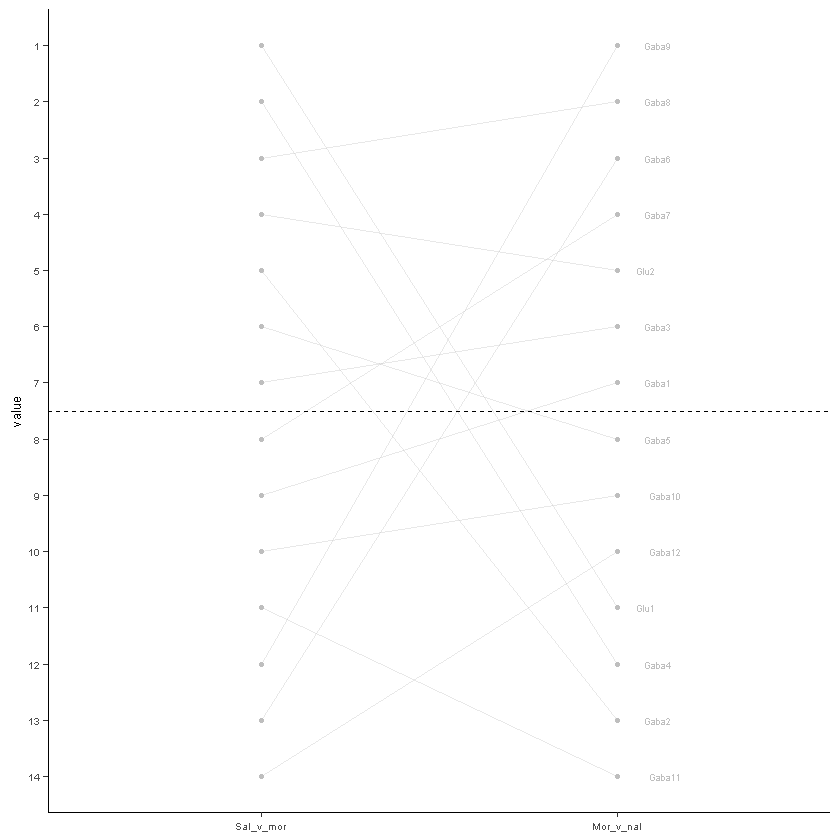

In [26]:
p2

#### Decoding accuracy CDFs

In [138]:
augur_nosal_shuffle <- readRDS(file='C:/Users/stuberadmin/Documents/scRNAseq/211119-RS-rv4/Neurons_only_iter2/augur/augur_mor_v_nal_shuffle.rds')
augur_nonal_shuffle <- readRDS(file='C:/Users/stuberadmin/Documents/scRNAseq/211119-RS-rv4/Neurons_only_iter2/augur/augur_sal_v_mor_shuffle.rds')
augur_nonal <- readRDS(file='C:/Users/stuberadmin/Documents/scRNAseq/211119-RS-rV4/Neurons_only_iter2/augur/augur_sal_v_mor.rds')
augur_nosal <- readRDS(file='C:/Users/stuberadmin/Documents/scRNAseq/211119-RS-rV4/Neurons_only_iter2/augur/augur_mor_v_nal.rds')

In [201]:
#sal vs mor
data1 <- data.frame(augur_nonal$results)
Gaba12_svm <- data1[data1$cell_type == 'Gaba12',]
data1<-data.frame(Gaba12_svm[Gaba12_svm$metric == 'roc_auc',]$estimate)
colnames(data1) <- c("Gaba12_svm.estimate")

In [202]:
#mor vs nal
data2 <- data.frame(augur_nosal$results)
Gaba12_mvn <- data2[data2$cell_type == 'Gaba12',]
data2<-data.frame(Gaba12_mvn[Gaba12_mvn$metric == 'roc_auc',]$estimate)
colnames(data2) <- c("Gaba12_svm.estimate")

In [203]:
#mor vs nal shuffle
data3 <- data.frame(augur_nosal_shuffle$results)
Gaba12_svms <- data3[data3$cell_type == 'Gaba12',]
data3<-data.frame(Gaba12_svms[Gaba12_svms$metric == 'roc_auc',]$estimate)
colnames(data3) <- c("Gaba12_svm.estimate")

In [204]:
p <- ggplot(data1, aes(x=Gaba12_svm.estimate)) + 
    geom_histogram(aes(y=cumsum(..count..)/dim(data1)[1]),fill='white', binwidth=0.1) +
    geom_histogram(data=data2, aes(x=Gaba12_svm.estimate, y=cumsum(..count..)/dim(data2)[1]), fill="white", binwidth=0.1) +
    geom_histogram(data=data3, aes(x=Gaba12_svm.estimate, y=cumsum(..count..)/dim(data3)[1]), fill="white", binwidth=0.1)

In [205]:
d <- ggplot_build(p)$data[[1]]
df1 <- data.frame(x = c(0, d$xmax), y = c(0, d$y))

d <- ggplot_build(p)$data[[2]]
df2 <- data.frame(x = c(0, d$xmax), y = c(0, d$y))

d <- ggplot_build(p)$data[[3]]
df3 <- data.frame(x = c(0, d$xmax), y = c(0, d$y))

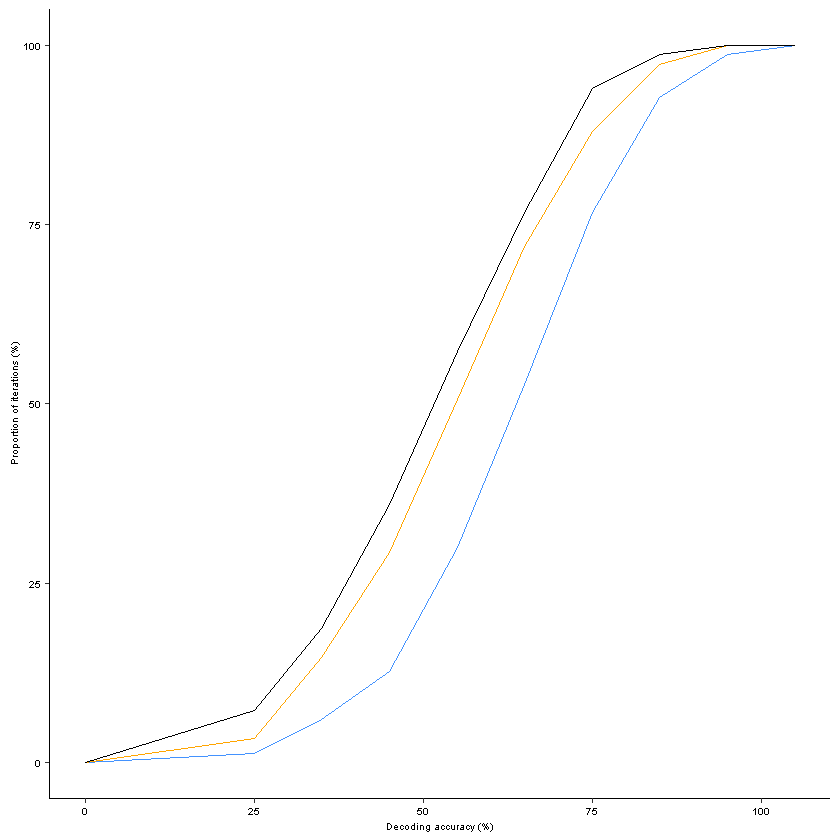

In [206]:
#df1 = sal vs mor
#df2 = mor vs nal
#df3 = mor vs nal shuffle

p2<- p + 
    geom_line(data = df1, aes(x = x*100, y = y*100), color = "#4392FE", size = 0.25) +
    geom_line(data = df2, aes(x = x*100, y = y*100), color = "orange", size = 0.25) +
    geom_line(data = df3, aes(x = x*100, y = y*100), color = "black", size = 0.25) +
        theme_classic() +
        theme(axis.title.x=element_text(size=6,colour = "black"),
              axis.title.y=element_text(size=6,colour = "black"),
          axis.text.y=element_text(size=6,colour = "black"),
          axis.text.x=element_text(size=6, colour = "black"),
          axis.line = element_line(size=0.25),
          axis.ticks = element_line(size=0.25)) +
    xlab("Decoding accuracy (%)") +
    ylab("Proportion of iterations (%)")
p2

ggsave(file="C:/Users/stuberadmin/Documents/scRNAseq/211119-RS-rv4/Neurons_only_iter2/augur/decode_accuracy_Gaba12_auc-roc-only.png", height=2, width=1.5)
ggsave(file="C:/Users/stuberadmin/Documents/scRNAseq/211119-RS-rv4/Neurons_only_iter2/augur/decode_accuracy_Gaba12_auc-roc-only.pdf", height=2, width=1.5)

Statistical testing

In [207]:
test <- wilcox.test(Gaba12_svm$estimate,Gaba12_svms$estimate)
test$p.value
test$statistic

[1] 4.652275e-14

W 
838310.5

In [208]:
test <- wilcox.test(Gaba12_mvn$estimate,Gaba12_svms$estimate)
test$p.value
test$statistic

[1] 0.7549669

W 
702232.5